In [1]:
import numpy as np
from numba import jit
from numba import njit, prange
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import time
import random
import os
import copy

# The Ising Model: An NP-Complete Ferromagnetic Model
### This project will focus on the implementation and optimization of the Ising model, a model intended to represent the interactions of ferromagnetic atoms in a condensed material.

In [2]:
def pickler(filename, data_to_save):
    """
    Writes Python data structure in memory to file on disk
    """
    with open(filename, 'wb') as file:
        pickle.dump(data_to_save, file)

def unpickler(filename):
    """
    Reads data on disk to Python data structure in memory
    """
    with open(filename, 'rb') as file:
        output = pickle.load(file)
    return output

def ising_generator(n, random_state=0):
    """
    Generates an nxn array of randomly assigned spin up (1) or spin down (0) elements to represent a 2D ferromagnetic material
        Inputs: 
            n, integer
        Outputs: 
            ising_arr, nxn np.array()
        Errors:
            AssertError: raised if input is not of type int.
    """
    assert type(n) is int, "Input must be of type int."
    ising_arr = np.random.randint(2,size = (n,n))
    ising_arr[ising_arr == 0] = -1
    return ising_arr

@jit(nopython = True)
def config_energy(ising_arr, J):    
    """
    Inputs:
        ising_arr: np.ndarray, randomly distributed 0s and 1s in square matrix
        J: Interaction term, determines if anti-ferromagnetic (+1) or ferromagnetic (-1) or non-interacting (0)
    Outputs:
        final_energy: total energy associated with configuration of ising_arr
    Errors:
        AssertError: ising_arr must be a square array
    """
    assert J == 1 or J == -1 or J == 0 #Validate input for J
    assert ising_arr.shape[0] == ising_arr.shape[1] #Assert square input array
    n = ising_arr.shape[0]
    num_interactions = 0
    hamiltonian = 0 #init hamiltonian summation
    for i in range(n):
        for j in range(n):
            ## Only need to calculate interaction with element below and element to the right to prevent double counting ferromagnetic interactions
            hamiltonian += -J * ising_arr[i][j] * ising_arr[ (i + 1) % n ][j] #Lower interaction, periodic boundary condition is maintained by the remainder calculation in the index
            hamiltonian += -J * ising_arr[i][j] * ising_arr[i][ (j +1 ) % n ] #Right interaction, periodic boundary condition is maintained by the remainder calculation in the index
    hamiltonian = hamiltonian / n**2 #Normalization of total hamiltonian energy to energy/site
    magnetism = np.sum(ising_arr) / n**2 #Total magnetism normalized to magnetization/site
    return hamiltonian, magnetism

@jit(nopython = True)
def single_flip(ising_arr, J, i, j, init_energy):
    """
    Computationally efficient method of calculating change in energy by flipping a site's magnetization 
    in MCMC and only looking at the change in the local environment's Hamiltonian energy, assumption of negligible 
    long-range interactions. 
    Inputs:
        ising_arr: square np.array() from ising_generator()
        J: Interaction term, int of either -1, 0, 1
        i: int, row index to flip
        j: int, column index to flip
        init_energy: float-like, energy of configuration before flip
    Outputs: 
        delta_e: Potential change in configurational energy as a result of the element's flip in magnetism
        new_e: Configurational energy following the flip in magnetism
    """
    n = ising_arr.shape[0]
    flipped_site = -ising_arr[i][j] #Reverse charge on site 
    delta_e = 0
    delta_e += -J * flipped_site * ising_arr[(i+1) % n][j] #upper interaction
    delta_e += -J * flipped_site * ising_arr[(i-1) % n][j] #lower interaction
    delta_e += -J * flipped_site * ising_arr[i][(j + 1) % n] #right interaction
    delta_e += -J * flipped_site * ising_arr[i][(j - 1) % n] # left interaction

    new_e = init_energy + delta_e

    return delta_e, new_e

#Old MCMC wrapper
#@jit(nopython = True)
# def markovchain_montecarlo(ising_arr, beta, mcmc_iterations, equilibriating_iterations, J=-1): #old function that doesn't work for some reason
#     """
#     Wrapper for a single Markov-Chain Monte Carlo optimization of a 2D Ising lattice.
#     Inputs:
#         ising_arr: Array to optimize from ising_generator function
#         beta: Temperature constant, float
#         mcmc_iterations: int, number of MCMC iterations to run following equilibriation
#         equilibriating_iterations: int, number of equilbriating iterations to run before recording the MCMC configurational energies to memory
#         savename: str, filename for which to pickle saved data to
#         J: int of either -1, 0 or 1, Ising interaction constant  
#     Outputs:
#         energies: array of configurational energies/step
#         magnetism: array of total magnetization/step
#     """
#     assert ising_arr.shape[0] == ising_arr.shape[1] #must be square array
#     n = ising_arr.shape[0] 
#     n_square = n**2 #used for normalization
#     init_energy = config_energy(ising_arr, J)
#     #Equilibriation
#     for i in range(equilibriating_iterations):
#         #### It is standard practice to run a set of equilbriation steps in order to account for bad initial guesses for a structure
#         #### Call MCMC optimization for equilbriating_iterations steps
#         #### Do not record energies/magnetism to memory
#         rand_i = np.random.randint(0, n)
#         rand_j = np.random.randint(0, n)
#         output = single_flip(ising_arr, J, rand_i, rand_j, init_energy) #calculate change in energy for altered configuration
#         delta_E = output[0]
#         new_E = output[1]
        
#         chance = np.random.rand()
#         # MCMC stochastic condition for accepting new condition
#         if delta_E < 0:
#             #If negative change in free energy, accept change 
#             ising_arr[rand_i, rand_j] *= -1
#             init_energy = new_E
#         elif chance <= np.exp(-delta_E * beta): 
#             #If positive change in free energy and odds are in favor of switch, accept change
#             ising_arr[rand_i, rand_j] *= -1
#             init_energy = new_E
#         elif chance > np.exp(-delta_E * beta): 
#             # Positive change in free energy, odds not in favor of switch, reject change
#             pass
    
#     energy_container = np.zeros(mcmc_iterations) #Preallocate container for MCMC energies
#     magnetism_container = np.zeros(mcmc_iterations) #Preallocate container for magnetizations per MCMC step
#     for i in range(mcmc_iterations):
#         #### Call MCMC optimization for mcmc_iterations steps
#         #### Write energies/magnetism to memory for plotting etc.
#         energy_container[i] = init_energy
#         magnetism_container[i] = np.sum(ising_arr) / n_square #update magnetization

#         #Select random site to flip
#         rand_i = np.random.randint(0, n)
#         rand_j = np.random.randint(0, n)
#         output = single_flip(ising_arr, J, rand_i, rand_j, init_energy) #calculate change in energy for altered configuration
#         delta_E = output[0]
#         new_E = output[1]
        
#         chance = np.random.rand() 
#         # MCMC stochastic condition for accepting new condition
#         if delta_E < 0:
#             #If negative change in free energy, accept change 
#             ising_arr[rand_i, rand_j] *= -1
#             init_energy = new_E
#         elif chance <= np.exp(-delta_E * beta): 
#             #If positive change in free energy and odds are in favor of switch, accept change
#             ising_arr[rand_i, rand_j] *= -1
#             init_energy = new_E
#         elif chance > np.exp(-delta_E * beta): 
#             # Positive change in free energy, odds not in favor of switch, reject change and ising_arr remains unchanged
#             pass

def mcmc_optimization_img(equilibriating_iterations: int, mcmc_iterations: int, n: int, beta: float, J: int): 
    """
    Wrapper for optimization of single 2D Ising lattice that saves images.
    Inputs: 
        equilibriating iterations: int, Number of iterations to be ran to equilbriate random structure. 
        mcmc_iterations: int, Number of iterations to be ran for main Markov Chain Monte Carlo optimization. Should be more than equilibriating iterations by at least an order of magnitude.
        n: int, size of 2D lattice, turned into square nxn matrix.
        beta: float, Boltzmann factor adding temperature factor into MCMC optimization
        J: int, -1, 0 or 1. Interaction term for Hamiltonian. Values outside of those listed prior will yield non-physical results. 
    Outputs: 
        energy_container: np.array, list of energies normalized per site, per MCMC optimization iteration.
        magnetism_container: np.array, list of magnetism values normalized per site, per MCMC optimization iteration.
        animation_container: np.array, the 2D array that can be used for visualization. 
    """
    energy_container = np.zeros(mcmc_iterations) #Preallocate container for MCMC energies
    magnetism_container = np.zeros(mcmc_iterations) #Preallocate container for magnetizations per MCMC step
    
    ising_arr = ising_generator(n)
    animation_container = []
    animation_save_index = 0
    animation_container.append(ising_arr) #Save initial lattice condition to animation array
    init_copy = copy.deepcopy(ising_arr)
    init_energy = config_energy(ising_arr, J)[0]
    n_square = n**2
    index = 0
    print(ising_arr)
    for index in range(equilibriating_iterations):
        #### Call MCMC optimization for equilibriating_iterations steps
        #### Energies/magnetizations not saved to memory during equilibriation
        for j in range(n_square): 
            # One equilibriating iteration considered to be accomplished after flipping n^2 sites. 
            # While this unfortunately creates O(N^2) time complexity, it is necessary to compare lattices of different sizes.
            #Select random site to flip
            rand_i = np.random.randint(0, n)
            rand_j = np.random.randint(0, n)
            output = single_flip(ising_arr, J, rand_i, rand_j, init_energy) #calculate change in energy for altered configuration
            delta_E = output[0]
            new_E = output[1]
            
            chance = np.random.rand() 
            # MCMC stochastic condition for accepting new condition
            if delta_E < 0:
                #If negative change in free energy, accept change 
                ising_arr[rand_i, rand_j] *= -1
                init_energy = new_E
            elif chance <= np.exp(-delta_E * beta): 
                #If positive change in free energy and odds are in favor of switch, accept change
                ising_arr[rand_i, rand_j] *= -1
                init_energy = new_E
            elif chance > np.exp(-delta_E * beta): 
                # Positive change in free energy, odds not in favor of switch, reject change and ising_arr remains unchanged
                pass
            animation_save_index += 1 
            if animation_save_index % 1000 == 0:    
                animation_container.append(ising_arr)
    j = 0
    for j in range(mcmc_iterations):
        #### Call MCMC optimization for mcmc_iterations steps
        #### Write energies/magnetism to memory for plotting etc.
        energy_container[j] = init_energy 
        magnetism_container[j] = np.sum(ising_arr)  #update magnetization
        for i in range(n_square):
            #Select random site to flip
            rand_i = np.random.randint(0, n)
            rand_j = np.random.randint(0, n)
            output = single_flip(ising_arr, J, rand_i, rand_j, init_energy) #calculate change in energy for altered configuration
            delta_E = output[0]
            new_E = output[1]
            
            chance = np.random.rand() 
            # MCMC stochastic condition for accepting new condition
            if delta_E < 0:
                #If negative change in free energy, accept change 
                ising_arr[rand_i, rand_j] *= -1
                init_energy = new_E
            elif chance <= np.exp(-delta_E * beta): 
                #If positive change in free energy and odds are in favor of switch, accept change
                ising_arr[rand_i, rand_j] *= -1
                init_energy = new_E
            elif chance > np.exp(-delta_E * beta): 
                # Positive change in free energy, odds not in favor of switch, reject change and ising_arr remains unchanged
                pass
            animation_save_index += 1
            if animation_save_index % 1000 == 0:    
                animation_container.append(ising_arr)
                print(ising_arr)
    #Normalization of energies & magnetization to a single site
    energy_container = energy_container / n_square
    magnetism_container = magnetism_container / n_square
    assert np.array_equal(init_copy, ising_arr) == False
    return energy_container, magnetism_container, animation_container

def mcmc_optimization(equilibriating_iterations: int, mcmc_iterations: int, n: int, beta: float, J: int): 
    """
    Wrapper for optimization of single 2D Ising lattice that doesn't save images.
    Inputs: 
        equilibriating iterations: int, Number of iterations to be ran to equilbriate random structure. 
        mcmc_iterations: int, Number of iterations to be ran for main Markov Chain Monte Carlo optimization. Should be more than equilibriating iterations by at least an order of magnitude.
        n: int, size of 2D lattice, turned into square nxn matrix.
        beta: float, Boltzmann factor adding temperature factor into MCMC optimization
        J: int, -1, 0 or 1. Interaction term for Hamiltonian. Values outside of those listed prior will yield non-physical results. 
    Outputs: 
        energy_container: np.array, list of energies normalized per site, per MCMC optimization iteration.
        magnetism_container: np.array, list of magnetism values normalized per site, per MCMC optimization iteration.
        animation_container: np.array, the 2D array that can be used for visualization. 
    """
    energy_container = np.zeros(mcmc_iterations) #Preallocate container for MCMC energies
    magnetism_container = np.zeros(mcmc_iterations) #Preallocate container for magnetizations per MCMC step
    
    ising_arr = ising_generator(n)
    
    init_energy = config_energy(ising_arr, J)[0]
    n_square = n**2
    index = 0
    for index in range(equilibriating_iterations):
        #### Call MCMC optimization for equilibriating_iterations steps
        #### Energies/magnetizations not saved to memory during equilibriation
        for j in range(n_square): 
            # One equilibriating iteration considered to be accomplished after flipping n^2 sites. 
            # While this unfortunately creates O(N^2) time complexity, it is necessary to compare lattices of different sizes.
            #Select random site to flip
            rand_i = np.random.randint(0, n)
            rand_j = np.random.randint(0, n)
            output = single_flip(ising_arr, J, rand_i, rand_j, init_energy) #calculate change in energy for altered configuration
            delta_E = output[0]
            new_E = output[1]
            
            chance = np.random.rand() 
            # MCMC stochastic condition for accepting new condition
            if delta_E < 0:
                #If negative change in free energy, accept change 
                ising_arr[rand_i, rand_j] *= -1
                init_energy = new_E
            elif chance <= np.exp(-delta_E * beta): 
                #If positive change in free energy and odds are in favor of switch, accept change
                ising_arr[rand_i, rand_j] *= -1
                init_energy = new_E
            elif chance > np.exp(-delta_E * beta): 
                # Positive change in free energy, odds not in favor of switch, reject change and ising_arr remains unchanged
                pass
            
    for j in range(mcmc_iterations):
        #### Call MCMC optimization for mcmc_iterations steps
        #### Write energies/magnetism to memory for plotting etc.
        energy_container[j] = init_energy 
        magnetism_container[j] = np.sum(ising_arr)  #update magnetization
        for i in range(n_square):
            #Select random site to flip
            rand_i = np.random.randint(0, n)
            rand_j = np.random.randint(0, n)
            output = single_flip(ising_arr, J, rand_i, rand_j, init_energy) #calculate change in energy for altered configuration
            delta_E = output[0]
            new_E = output[1]
            
            chance = np.random.rand() 
            # MCMC stochastic condition for accepting new condition
            if delta_E < 0:
                #If negative change in free energy, accept change 
                ising_arr[rand_i, rand_j] *= -1
                init_energy = new_E
            elif chance <= np.exp(-delta_E * beta): 
                #If positive change in free energy and odds are in favor of switch, accept change
                ising_arr[rand_i, rand_j] *= -1
                init_energy = new_E
            elif chance > np.exp(-delta_E * beta): 
                # Positive change in free energy, odds not in favor of switch, reject change and ising_arr remains unchanged
                pass

    #Normalization of energies & magnetization to a single site
    energy_container = energy_container / n_square
    magnetism_container = magnetism_container / n_square
    animation_container = []
    return energy_container, magnetism_container, animation_container

In [119]:
energy, mag, animation = mcmc_optimization(3, 50, 10, 5, -1)

[[ 1  1 -1  1  1  1 -1  1  1 -1]
 [-1 -1  1  1  1 -1  1  1 -1 -1]
 [-1 -1  1  1 -1 -1  1  1 -1 -1]
 [ 1 -1 -1  1 -1  1 -1  1  1 -1]
 [-1  1  1 -1  1 -1 -1  1 -1 -1]
 [-1  1  1 -1 -1  1  1 -1 -1  1]
 [-1 -1  1  1  1  1 -1 -1 -1  1]
 [-1 -1 -1 -1  1 -1  1 -1 -1 -1]
 [-1  1 -1  1 -1 -1 -1 -1  1  1]
 [-1 -1 -1 -1  1 -1 -1 -1  1  1]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1  1  1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[[-1 -1

In [122]:
class MCMC_optimization: #
    def __init__(self, n, beta, equil_iter, mcmc_iter, J):
        self.n = n
        self.beta = beta
        self.equil_iter = equil_iter
        self.mcmc_iter = mcmc_iter
        self.J = J
        self.savename = f"{n}_{beta}_{equil_iter}_{mcmc_iter}_{J}"
    
#Parameter grid testing for MCMC configs
#j_space = [-1, 1] #Anti-ferromagnetic interactions, ferromagnetic interactions 
j_space = [-1] #Choosing to ignore +1 interaction as it only leads to the whole lattice going towards -1, not really an interesting optimization
n_space = [10, 25, 50, 75, 100] #10x10 element lattice, 50x50 element lattice, ...
#n_space = [10]
beta_space = [.01, .1, .5, 1, 3, 4, 5, 10] #self explanatory
equil_iter_space = [100] # We really shouldn't need more than this
mcmc_iter_space = [1000, 2000, 5000, 10000]

#Defining all 160 configurations to be tested
parameter_space = [] #container holding parameters for all relaxations to be ran
for n in n_space:
    for beta in beta_space:
        for eq in equil_iter_space:
            for mcmc in mcmc_iter_space:
                for J_config in j_space:
                    parameter_space.append(MCMC_optimization(n, beta, eq, mcmc, J_config))

num_runs = len(parameter_space)
for i in range(len(parameter_space)):
    remaining_runs = len(parameter_space) - (i + 1)
    testing_params = parameter_space[i]
    
    n = testing_params.n
    beta = testing_params.beta
    equil_iter = testing_params.equil_iter
    mcmc_iter = testing_params.mcmc_iter
    J = testing_params.J
    savename = testing_params.savename
    begin_time = time.time()
    
    energies, magnetism, animation_arr = mcmc_optimization(equil_iter, mcmc_iter, n, beta, J)
    end_time = time.time()
    runtime = end_time - begin_time
    print(f"Runtime for configuration {savename} was {runtime} seconds, {remaining_runs} relaxations remaining of {num_runs} runs.")
    
    #Dictionary to hold data and information about a run
    run_dict = {}
    run_dict["Runtime"] = runtime
    run_dict["Energies"] = energies
    run_dict["Magnetism"] = magnetism
    run_dict["Animation Arrays"] = animation_arr
    run_dict["params"] = savename
    
    #Save run to file
    pickler(savename, run_dict)
    os.system(f"mv {savename} ./mcmc_runs/")

Runtime for configuration 10_0.01_100_1000_-1 was 0.5007531642913818 seconds, 159 relaxations remaining of 160 runs.
Runtime for configuration 10_0.01_100_2000_-1 was 0.6414642333984375 seconds, 158 relaxations remaining of 160 runs.
Runtime for configuration 10_0.01_100_5000_-1 was 1.4933528900146484 seconds, 157 relaxations remaining of 160 runs.
Runtime for configuration 10_0.01_100_10000_-1 was 2.9661879539489746 seconds, 156 relaxations remaining of 160 runs.
Runtime for configuration 10_0.1_100_1000_-1 was 0.3373579978942871 seconds, 155 relaxations remaining of 160 runs.
Runtime for configuration 10_0.1_100_2000_-1 was 0.6316759586334229 seconds, 154 relaxations remaining of 160 runs.
Runtime for configuration 10_0.1_100_5000_-1 was 1.4864449501037598 seconds, 153 relaxations remaining of 160 runs.
Runtime for configuration 10_0.1_100_10000_-1 was 3.016770124435425 seconds, 152 relaxations remaining of 160 runs.
Runtime for configuration 10_0.5_100_1000_-1 was 0.3367071151733398

In [106]:
#Attempts at visualization I give up for tonight
import imageio
import matplotlib.animation as animation
all_runs = os.listdir("mcmc_runs")
split_runs = [x.split("_") for x in all_runs]
n10_runs = []
for run in split_runs:
    if run[0] == "10":
        n10_runs.append(all_runs[split_runs.index(run)])
n10_run_dicts = [unpickler(f"mcmc_runs/{run}") for run in n10_runs]
#print(n10_run_dicts[-1]["Animation Arrays"])
plot_index = 0
frame_index = 0
filenames = []
# #temp = n10_run_dicts[0]["Energies"]
# #tester = [ising_generator(10) for x in range(15)]
# fig = plt.figure()
# ims = []
import plotly.graph_objects as go
def get_ising_plot(spin):
    img = np.array(spin, dtype = object)
    for i in range(len(spin[0])):
        for j in range(len(spin[1])):
            if spin[i,j] == 1:
                img[i,j] = [255,255,255]
            else:
                img[i,j] = [0,0,0]
    image = go.Image(z=img)
    return image

# Stich together plotly frames to create an animation 
def get_ising_video(frames, initial_spin):
    fig = go.Figure(
    data=[get_ising_plot(initial_spin)], 
    layout=go.Layout(
        title = "Ising model demonstration",
        xaxis = {'showticklabels':False},
        yaxis = {'showticklabels':False},
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, dict(frame=dict(duration=1))])])]
        ), frames=frames )
    return fig
# frames = []
# for i in n10_run_dicts[-1]["Animation Arrays"]:
#     frame = go.Frame(data = get_ising_plot(i))
#     frames.append(frame)
# fig = get_ising_video(frames, n10_run_dicts[0]["Animation Arrays"][0])
# fig.show()
all_frames = n10_run_dicts[5]["Animation Arrays"]
assert np.array_equal(all_frames[0], all_frames[-1]) == False

# for image in n10_run_dicts[0]["Animation Arrays"]:
#     # im = plt.imshow(image, animated = True)
#     # ims.append(im)
#     if plot_index % 5 == 0:
#         plt.imshow(image)
#         plt.savefig(f"animations/plot_{frame_index}.png")
#         filenames.append(f"animations/plot_{frame_index}.png")
#         frame_index += 1
#     plot_index += 1
# # ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
# # ani.save('dynamic_images.mp4')
# # plt.show()  
# # #for random in tester:
    
# with imageio.get_writer("test_gif.gif", mode="I") as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)
# # temp = ising_generator(10)
# # plt.imshow(temp)



AssertionError: 

dict_keys(['Runtime', 'Energies', 'Magnetism', 'Animation Arrays', 'params'])


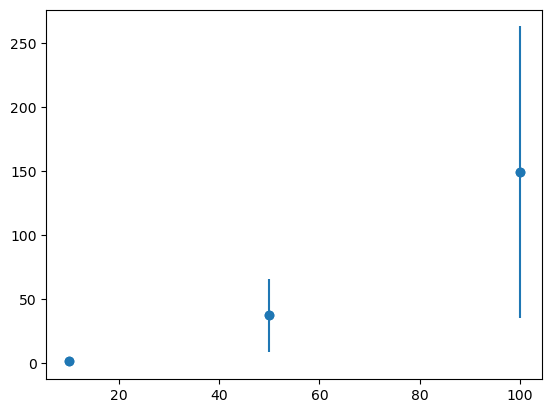

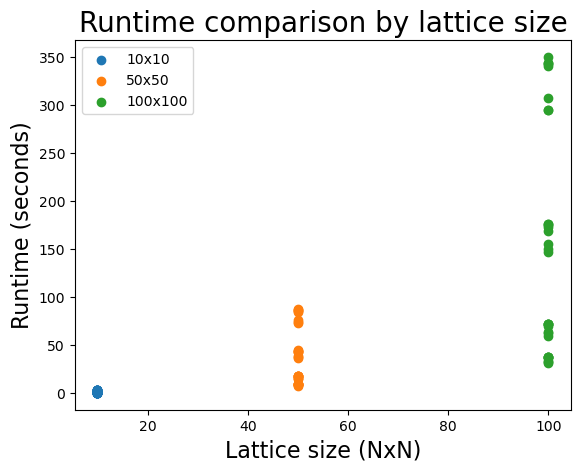

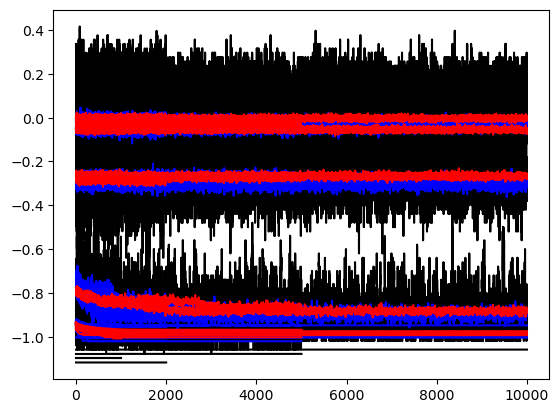

In [3]:
#Relaxation analysis
all_runs = os.listdir("mcmc_runs")
split_runs = [x.split("_") for x in all_runs]
n10_runs = []
n50_runs = []
n100_runs = []

for run in split_runs:
    if run[0] == "10":
        n10_runs.append(all_runs[split_runs.index(run)])
    elif run[0] == "50":
        n50_runs.append(all_runs[split_runs.index(run)])
    elif run[0] == "100":
        n100_runs.append(all_runs[split_runs.index(run)])

#All data, separated by lattice size
n10_run_dicts = [unpickler(f"mcmc_runs/{run}") for run in n10_runs]
n50_run_dicts = [unpickler(f"mcmc_runs/{run}") for run in n50_runs]
n100_run_dicts = [unpickler(f"mcmc_runs/{run}") for run in n100_runs]
print(n10_run_dicts[0].keys())
#Runtime analysis
n10_runtimes = [float(x["Runtime"]) for x in n10_run_dicts]
n10_runtime_avg = np.mean(n10_runtimes)
n10_runtime_std = np.std(n10_runtimes)

n50_runtimes = [float(x["Runtime"]) for x in n50_run_dicts]
n50_runtime_avg = np.mean(n50_runtimes)
n50_runtime_std = np.std(n50_runtimes)

n100_runtimes = [float(x["Runtime"]) for x in n100_run_dicts]
n100_runtime_avg = np.mean(n100_runtimes)
n100_runtime_std = np.std(n100_runtimes)

mean_plotx = [10,50,100]
mean_ploty = [n10_runtime_avg, n50_runtime_avg, n100_runtime_avg]
mean_plot_error = [n10_runtime_std, n50_runtime_std, n100_runtime_std]
plt.scatter(mean_plotx,mean_ploty)
plt.errorbar(mean_plotx, mean_ploty, yerr=mean_plot_error, fmt="o")
plt.show()

n10_plotx = [10*x for x in np.ones(len(n10_runtimes))]
n50_plotx = [50*x for x in np.ones(len(n50_runtimes))]
n100_plotx = [100*x for x in np.ones(len(n100_runtimes))]

plt.figure(dpi = 100)
plt.title("Runtime comparison by lattice size", fontsize = 20)
plt.scatter(n10_plotx, n10_runtimes, label = "10x10")
plt.scatter(n50_plotx, n50_runtimes, label = "50x50")
plt.scatter(n100_plotx, n100_runtimes, label ="100x100")
plt.xlabel("Lattice size (NxN)", fontsize = 16)
plt.ylabel("Runtime (seconds)", fontsize = 16)
plt.legend()
plt.show()

#Convergence analysis
n10_energies = [run["Energies"] for run in n10_run_dicts]
n10_plot_steps = [np.arange(len(x)) for x in n10_energies]

n50_energies = [run["Energies"] for run in n50_run_dicts]
n50_plot_steps = [np.arange(len(x)) for x in n50_energies]

n100_energies = [run["Energies"] for run in n100_run_dicts]
n100_plot_steps = [np.arange(len(x)) for x in n100_energies]

for n10x_en, n10y_en in zip(n10_plot_steps, n10_energies):
    plt.plot(n10x_en, n10y_en, 'k')
for n50x_en, n50y_en in zip(n50_plot_steps, n50_energies):
    plt.plot(n50x_en, n50y_en, 'b')
for n100x_en, n100y_en in zip(n100_plot_steps, n100_energies):
    plt.plot(n100x_en, n100y_en, 'r')

plt.show()

In [16]:
#self.savename = f"{n}_{beta}_{equil_iter}_{mcmc_iter}_{J}"
def run_query(run_directory = "mcmc_runs", n = None, beta = None, equil_iter = None, mcmc_iter = None, J = None):
    """
    Function to grab a set of relaxation data based on set of filters. All runs for a given parameter set can be queried by passing None for the respective parameter.
    
    Inputs: 
        run_directory: str, directory where relaxation files are stored
        For all other inputs, see mcmc_optimization function definition
    Outputs:
        run_dicts: list, list of dictionaries gathered by query
    """
    # Getting filenames
    all_runs = os.listdir(run_directory)
    split_directories = [run.split("_") for run in all_runs]
    # Input validation
    input_list = [n, beta, equil_iter, mcmc_iter, J]
    is_none = [x != None for x in input_list]

    runname_container = []
    num_conditions = np.count_nonzero(np.array(is_none))
    
    for run in split_directories:
        num_satisfied_conditions = 0
        for index in range(len(input_list)):
            if input_list[index] != None: 
                if run[index] == input_list[index]:
                    num_satisfied_conditions += 1
        if num_satisfied_conditions == num_conditions:
            runname_container.append(all_runs[split_directories.index(run)])
    
    run_dicts = []
    for run_name in runname_container:
        run_dicts.append(unpickler(f"{run_directory}/{run_name}"))
    return run_dicts



[{'Runtime': 1.555042028427124,
  'Energies': array([-0.2012, -0.2212, -0.2012, ..., -0.2212, -0.1212, -0.2012]),
  'Magnetism': array([ 0.04,  0.06,  0.02, ..., -0.04,  0.04,  0.1 ]),
  'Animation Arrays': [],
  'params': '10_0.5_100_5000_-1'},
 {'Runtime': 2.9661879539489746,
  'Energies': array([0.0572, 0.0972, 0.1372, ..., 0.0772, 0.1172, 0.0372]),
  'Magnetism': array([ 0.06, -0.04,  0.04, ...,  0.02,  0.1 , -0.14]),
  'Animation Arrays': [],
  'params': '10_0.01_100_10000_-1'},
 {'Runtime': 3.0946249961853027,
  'Energies': array([-0.34, -0.3 , -0.28, ..., -0.24, -0.22, -0.38]),
  'Magnetism': array([-0.12,  0.08,  0.04, ...,  0.04,  0.04, -0.1 ]),
  'Animation Arrays': [],
  'params': '10_0.5_100_10000_-1'},
 {'Runtime': 0.3829820156097412,
  'Energies': array([-1.098, -1.098, -1.098, -1.098, -1.098, -1.098, -1.098, -1.098,
         -1.098, -1.098, -1.098, -1.098, -1.098, -1.098, -1.098, -1.098,
         -1.098, -1.098, -1.098, -1.098, -1.098, -1.098, -1.098, -1.098,
         -1